In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import skimage.io as skio
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import xmltodict
import zarr

In [2]:
maps_proj = Path('./A2-box159853-Maps3/')
maps_metadata = maps_proj.joinpath('Metadata')

ids = [f for f in maps_metadata.iterdir() if f.is_dir() and f.joinpath('image_pyramid','0','data').exists()]

print(f'found {len(ids)} image folders with data')
for i in ids:
    print(i.name, i.joinpath('image_pyramid').exists())

found 9 image folders with data
2b4696be-0e22-4e01-8a84-eefa41dd6003 True
2ce88bc8-1732-4489-a39c-c04c1a7bd4ec True
318e09c9-440b-40f9-8665-f534c6617cac True
3d4ad21a-0823-47fd-9de8-f2a636bdb40e True
3e0f709c-c757-4590-901e-081a82843a61 True
4a0c16b8-bc7d-40d8-9338-61c49391d711 True
554bd245-54a7-4bf0-9a93-52f8534f259c True
c93cb68e-c809-4482-9815-eeb82f3ad514 True
d0631e1a-5b69-4896-be8d-3ffebadf7616 True


(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

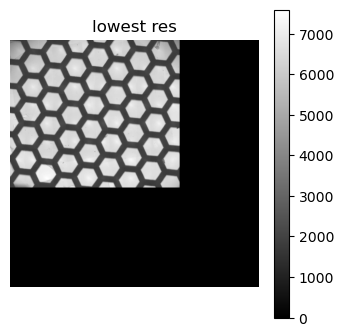

In [3]:
# this is user input. Later we can find this programatically
#img_id = '3e0f709c-c757-4590-901e-081a82843a61'
img_id = ids[4].name
maps_proj = Path('./A2-box159853-Maps3/')

maps_metadata = maps_proj.joinpath('Metadata')

img_folder = maps_metadata.joinpath(img_id)

image_pyramid = img_folder.joinpath('image_pyramid')

stitching_path = img_folder.joinpath('StitchingData.xml')

# 0 here stands for chanel 0, I always have ch 0 not more
pyramid_data_path = image_pyramid.joinpath('0','data')

# looking at the lowest res image
lvl_0 = pyramid_data_path.joinpath('l_0', 'c_0')

tile_0 = skio.imread(lvl_0.joinpath('tile_0.tif'), plugin="tifffile")
print(tile_0.shape)

plt.figure(figsize=(4, 4), dpi=100)
plt.imshow(tile_0, cmap="gray")
plt.colorbar()
plt.title("lowest res")
plt.axis('off')

In [4]:
with open(stitching_path, "rb") as f:
    stitching_dict = xmltodict.parse(f, xml_attribs=True)

stitching_dict['StitchingDataStore'].keys()

dict_keys(['@z:Id', '@xmlns', '@xmlns:i', '@xmlns:z', 'registrations', 'tileSet'])

In [5]:
with open(image_pyramid.joinpath('MultiChannelParams.xml'), "rb") as f:
    multichannel_dict = xmltodict.parse(f, xml_attribs=True)

ch_name = multichannel_dict['MultiChannelParameters']['Channel']['Name']
print(f'name of channel in image: {ch_name}')

name of channel in image: Transmitted Light


In [6]:
with open(pyramid_data_path.joinpath('pyramid.xml'), "rb") as f:
    pyramid_dic = xmltodict.parse(f, xml_attribs=True)
pyramid_dic['root']['imageset'].keys()

dict_keys(['@url', '@levels', '@width', '@height', '@tileWidth', '@tileHeight', '@tileOverlap', '@projection', '@maxZoom', '@step', '@subRect'])

In [7]:
n_lvl = pyramid_dic['root']['imageset']['@levels']
height = pyramid_dic['root']['imageset']['@height']
width = pyramid_dic['root']['imageset']['@width']
overlap = pyramid_dic['root']['imageset']['@tileOverlap']
res_step = pyramid_dic['root']['imageset']['@step']
t_w = pyramid_dic['root']['imageset']['@tileWidth']
t_h = pyramid_dic['root']['imageset']['@tileHeight']

print(f'The pyramid has {n_lvl} levels')
print(f'total img size: {width} x {height}, not counting black padding')
print(f'with an overlap of: {overlap}')
print(f'the resolution step is: {res_step}')
print(f'single image shape: {t_w} x {t_h}')

pix_size_x = pyramid_dic['root']['metadata']['pixelsize']['x']
pix_size_y = pyramid_dic['root']['metadata']['pixelsize']['y']

print(f'the pixel size is: {pix_size_x}, I am unsure of the units, have to chek in scope')

The pyramid has 5 levels
total img size: 11162 x 9811, not counting black padding
with an overlap of: 0
the resolution step is: 2
single image shape: 1024 x 1024
the pixel size is: 1.602883e-007, I am unsure of the units, have to chek in scope


In [8]:
full_res_path = pyramid_data_path.joinpath(f'l_{int(n_lvl)-1}')

col_folders = [f for f in full_res_path.iterdir() if f.is_dir() and f.name.startswith('c_')]

print(f'found {len(col_folders)} column folders')


found 11 column folders


In [9]:
col_idx = 0
col_folder = col_folders[col_idx]

col_tiles = [f for f in col_folder.iterdir() if f.is_file and f.name.endswith('.tif')]
n_tiles = len(col_tiles)
print(f'found {n_tiles} tiles in col {col_idx}')

found 10 tiles in col 0


In [10]:
def get_col_df(col_folder):
    #col_folder = col_folders[col_idx]
    c_name = str(col_folder.name).split('c_')
    c_name = c_name[1]
    print(c_name)
    col_tiles = [f for f in col_folder.iterdir() if f.is_file and f.name.endswith('.tif')]

    tmp_img = skio.imread(col_tiles[0], plugin="tifffile")
    img_dtype = tmp_img.dtype

    #n_tiles = len(col_tiles)
    col_df = pd.DataFrame(columns=['row_idx', 'col_idx', 'tif_path','corner_row','corner_col','size_row','size_col','data_type'])
    col_df['tif_path'] = col_tiles
    col_df['col_idx'] = c_name
    col_df['data_type'] = img_dtype
    col_df['size_row'] = tmp_img.shape[0]
    col_df['size_col'] = tmp_img.shape[1]


    row_idx = []
    cor_row = []
    cor_col = []

    for idx, val in enumerate(col_tiles):
        row_idx.append(idx)
        cor_row.append(idx*tmp_img.shape[0])
        cor_col.append(int(c_name)*tmp_img.shape[1])



    col_df['row_idx'] = row_idx
    col_df['corner_row'] = cor_row
    col_df['corner_col'] = cor_col

    return col_df

def rm_tree(pth):
    pth = Path(pth)
    for child in pth.glob('*'):
        if child.is_file():
            child.unlink()
        else:
            rm_tree(child)
    pth.rmdir()

In [11]:
col_list = []
for col_folder in (col_folders):

    col_list.append(get_col_df(col_folder))

# concatenating df1 and df2 along rows
total_df = pd.concat(col_list, axis=0)
total_df.reset_index(drop=True, inplace=True)
total_df

0
1
10
2
3
4
5
6
7
8
9


,row_idx,col_idx,tif_path,corner_row,corner_col,size_row,size_col,data_type
0,0,0,A2-box159853-Maps3\Metadata\3e0f709c-c757-4590...,0,0,1024,1024,uint16
1,1,0,A2-box159853-Maps3\Metadata\3e0f709c-c757-4590...,1024,0,1024,1024,uint16
2,2,0,A2-box159853-Maps3\Metadata\3e0f709c-c757-4590...,2048,0,1024,1024,uint16
3,3,0,A2-box159853-Maps3\Metadata\3e0f709c-c757-4590...,3072,0,1024,1024,uint16
4,4,0,A2-box159853-Maps3\Metadata\3e0f709c-c757-4590...,4096,0,1024,1024,uint16
...,...,...,...,...,...,...,...,...
105,5,9,A2-box159853-Maps3\Metadata\3e0f709c-c757-4590...,5120,9216,1024,1024,uint16
106,6,9,A2-box159853-Maps3\Metadata\3e0f709c-c757-4590...,6144,9216,1024,1024,uint16
107,7,9,A2-box159853-Maps3\Metadata\3e0f709c-c757-4590...,7168,9216,1024,1024,uint16
108,8,9,A2-box159853-Maps3\Metadata\3e0f709c-c757-4590...,8192,9216,1024,1024,uint16


In [12]:
# total_df = get_col_df(col_folders, 2) # for testing

max_row = total_df.loc[total_df['corner_row'].idxmax()]
max_col = total_df.loc[total_df['corner_col'].idxmax()]
total_row = max_row['corner_row'] + max_row['size_row']
total_col = max_col['corner_col'] + max_col['size_col']
total_dype = max_col['data_type']
print(f'total image size: {total_row}, {total_col}')


total image size: 10240, 11264


In [13]:
z0_str = f"./{img_id}.zarr"
z0_path = Path(z0_str)

if z0_path.exists():
  rm_tree(z0_path)
  
store = zarr.DirectoryStore(z0_path)
chunk_size = total_df['size_row'].max()
print(f'Chunk size: {chunk_size},{chunk_size}')
z = zarr.creation.open_array(store=store, mode='a', shape=(total_row, total_col), chunks=(chunk_size,chunk_size), dtype=total_dype)
z

Chunk size: 1024,1024


<zarr.core.Array (10240, 11264) uint16>

In [14]:
#img_array = np.zeros((total_row, total_col), dtype=total_dype)

#print(img_array.shape)

for index, row in total_df.iterrows():
  tmp_img = skio.imread(row['tif_path'], plugin="tifffile")

  row_1 = row['corner_row']
  row_2 = row_1 + row['size_row']
  col_1 = row['corner_col']
  col_2 = col_1 + row['size_col']

  z[row_1:row_2, col_1:col_2] = tmp_img



In [15]:
import dask.array as da
# like numpy.mean, but maintains dtype, helper function
def mean_dtype(arr, **kwargs):
    return np.mean(arr, **kwargs).astype(arr.dtype)

In [16]:
# it is still not quite clear to me why, but we need to rechunk de data at this stage
# if not zarr writting later on will fail
d0 = da.from_zarr(store).rechunk(chunk_size,chunk_size)
d0

dask.array<from-zarr, shape=(10240, 11264), dtype=uint16, chunksize=(1024, 1024), chunktype=numpy.ndarray>

In [17]:
d1 = da.coarsen(mean_dtype, d0, {0:2,1:2}).rechunk(int(chunk_size/2),int(chunk_size/2))

d2 = da.coarsen(mean_dtype, d0, {0:4,1:4}).rechunk(int(chunk_size/2),int(chunk_size/2))

d3 = da.coarsen(mean_dtype, d0, {0:8,1:8}).rechunk(int(chunk_size/2),int(chunk_size/2))
d3

dask.array<rechunk-merge, shape=(1280, 1408), dtype=uint16, chunksize=(512, 512), chunktype=numpy.ndarray>

In [18]:
from ome_zarr.io import parse_url
from ome_zarr.writer import write_multiscale
from ome_zarr.writer import write_multiscales_metadata

In [19]:
# I can probably build this programmatically, for the moment I take a shortcut. 
# This assumes an image with full resolution and one downscale by 2x2
# here I assume that the original scale was in m but I am not sure

initial_pix_size = float(pix_size_x) / 1e-8
initial_pix_unit = 'nanometer'
coordtfs = [
        [{'type': 'scale', 'scale': [initial_pix_size,initial_pix_size]},
         {'type': 'translation', 'translation': [0, 0]}],
        [{'type': 'scale', 'scale': [initial_pix_size*2,initial_pix_size*2]},
         {'type': 'translation', 'translation': [0, 0]}],
        [{'type': 'scale', 'scale': [initial_pix_size*4,initial_pix_size*4]},
         {'type': 'translation', 'translation': [0, 0]}],
        [{'type': 'scale', 'scale': [initial_pix_size*8,initial_pix_size*8]},
         {'type': 'translation', 'translation': [0, 0]}],
        ]
axes = [{'name': 'y', 'type': 'space', 'unit': initial_pix_unit},
        {'name': 'x', 'type': 'space', 'unit': initial_pix_unit}]

In [20]:
# Open the zarr group manually
path_str = "./"+img_id+"-ome.zarr"
path = Path(path_str)

if path.exists():
  rm_tree(path)


store = parse_url(path, mode='w').store
root = zarr.group(store=store)

# Use OME write multiscale;
write_multiscale([d0, d1, d2, d3],
        group=root, axes=axes, coordinate_transformations=coordtfs
        )
# add omero metadata: the napari ome-zarr plugin uses this to pass rendering
# options to napari.
root.attrs['omero'] = {
        'channels': [{
                'color': 'ffffff',
                'label': ch_name,
                'active': True,
                'window': {
                  'end': d0.max().compute(),
                  'max': 65535,
                  'start': d0.min().compute(),
                  'min': 0,
                }
                }]
        }

In [21]:
if z0_path.exists():
  rm_tree(z0_path)